In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import holidays

# Notes

1. For *Type* is "Receive", Created Date is the same as Receive Date, suggests that the package was delivered to the transport center/warehouse
2. *Pickup Duration/Collect Duration* = *Withdraw Date* - *Delivery Date*
3. For "Receive", Delivery Duration = Delivery Date - Receive Date
4. For "Send", no delivery duration
4. Delivery Date infers Expire Date -> Delivery Date is the timestamp when the the package occupies the station

# Receive
The package is transfered from the transport center to the locker near the customer

1. Created / Receive Date: the day the package is registered in the system
2. Delivery Date: the day the package is handed over to the locker: Delivery Duration = Delivery Date - Created Date
3. Expire Date = Delivery Date + 24-72 hours
4. Withdraw Date: the day the package is picked up from the locker: Pickup Duration = Withdraw Date - Delivery Date

# Send
The package is carried to the locker by the customer, and the collected by the carrier

1. Created Date: the day the package is registered in the system
2. Delivery Date: the day the package is handed over to the locker by the SENDER: Send Duration = Delivery Date - Created Date
3. Expire Date = Delivery Date + 24-72 hours
4. Withdraw Date: the day the package is picked up from the locker by the CARRIER: Collect Duration = Withdraw Date - Delivery Date
5. Receive Date: the day the package comes to the transport center/warehouse

# Direct
The package is temporarily placed inside the locker and waited for the same/other customer to pick up later

1. Created Date / Delivery Date: the day the package is registered in the system
2. Withdraw Date: the day the package is picked up by other/the same customer at that locker: Pickup Duration = Withdraw Date - Delivery Date
3. Expire Date = Delivery Date + 24-72 hours

In [2]:
df = pd.read_csv("dataset/locker_nyc.csv")
df.head(1)

,Type,Status,Created Date,Delivered,Delivery Date,Received,Receive Date,Withdrawn,Withdraw Date,Expired,...,Address,Latitude,longitude,Borough,Community Board,Council District,BIN,BBL,Census Tract (2020),Neighborhood Tabulation Area (NTA) (2020)
0,Receive,Completed,04/10/2024 04:57:00 PM,True,04/10/2024 06:34:00 PM,True,04/10/2024 04:57:00 PM,True,04/11/2024 04:54:00 PM,True,...,"508 East 12th St, Newyork, NY 10009",40.728865,-73.980838,Manhattan,103,2,1005169,1004050012,34,MN0303


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12276 entries, 0 to 12275
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Type                                       12276 non-null  object 
 1   Status                                     12276 non-null  object 
 2   Created Date                               12276 non-null  object 
 3   Delivered                                  12276 non-null  bool   
 4   Delivery Date                              12270 non-null  object 
 5   Received                                   12276 non-null  bool   
 6   Receive Date                               11995 non-null  object 
 7   Withdrawn                                  12276 non-null  bool   
 8   Withdraw Date                              12276 non-null  object 
 9   Expired                                    12276 non-null  bool   
 10  Expire Date           

In [4]:
# Convert Receive Date, Withdraw Date, Delivery Date and Expire Date to datetime, original format: 04/15/2024 04:34:00 PM
df['Created Date'] = pd.to_datetime(df['Created Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Receive Date'] = pd.to_datetime(df['Receive Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Withdraw Date'] = pd.to_datetime(df['Withdraw Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Expire Date'] = pd.to_datetime(df['Expire Date'], format='%m/%d/%Y %I:%M:%S %p')

In [5]:
# Duration features
dur_features = [col for col in df.columns if 'Duration' in col]
dur_features

['Pickup Duration', 'Delivery Duration', 'Collect Duration', 'Send Duration']

In [6]:
# Remove Withdrawn and Expired column
df = df.drop(columns=["Status", "Withdrawn", "Expired"], errors="ignore")
# Remove duplicates
df = df.drop_duplicates()

In [7]:
# profile = ProfileReport(df,title="Locker Report")
# profile.to_notebook_iframe()

In [8]:
missing_counts = df.groupby('Type')[['Receive Date', "Delivery Date", "Send Duration", "Delivery Duration", 'Pickup Duration', "Collect Duration"]].apply(lambda x: x.isnull().sum())
missing_counts

,Receive Date,Delivery Date,Send Duration,Delivery Duration,Pickup Duration,Collect Duration
Type,,,,,,
Direct,160,0,161,161,0,161
Receive,0,6,11894,6,6,11894
Send,119,0,0,219,219,0


In [9]:
df[df['Type'] == 'Direct'][["Type", "Created Date", "Receive Date", "Delivery Date", "Expire Date", "Withdraw Date", "Pickup Duration", "Collect Duration", "Send Duration"]].head()

,Type,Created Date,Receive Date,Delivery Date,Expire Date,Withdraw Date,Pickup Duration,Collect Duration,Send Duration
174,Direct,2024-05-07 17:45:00,NaT,2024-05-07 17:45:00,2024-05-10 17:45:00,2024-05-07 20:50:00,00.03.04.51,NaN,NaN
417,Direct,2024-06-13 16:13:00,NaT,2024-06-13 16:13:00,2024-06-16 16:13:00,2024-06-13 20:49:00,00.04.35.37,NaN,NaN
418,Direct,2024-06-13 16:14:00,NaT,2024-06-13 16:14:00,2024-06-16 16:14:00,2024-06-13 20:49:00,00.04.35.02,NaN,NaN
419,Direct,2024-06-13 16:15:00,NaT,2024-06-13 16:15:00,2024-06-14 16:15:00,2024-06-26 08:59:00,12.16.44.07,NaN,NaN
697,Direct,2024-07-26 18:01:00,NaT,2024-07-26 18:01:00,2024-07-29 18:01:00,2024-07-26 21:38:00,00.03.37.26,NaN,NaN


In [10]:
# Remove records where Type = Send or Receive and Delivery Date is null => Package has not been carried to the locker
df = df[~(((df['Type'] == 'Send') | (df['Type'] == 'Receive')) & (df['Delivery Date'].isnull()))]

In [11]:
# Expired = df['Expire Date'] < Withdraw Date
df['Expired'] = df['Expire Date'] < df['Withdraw Date']

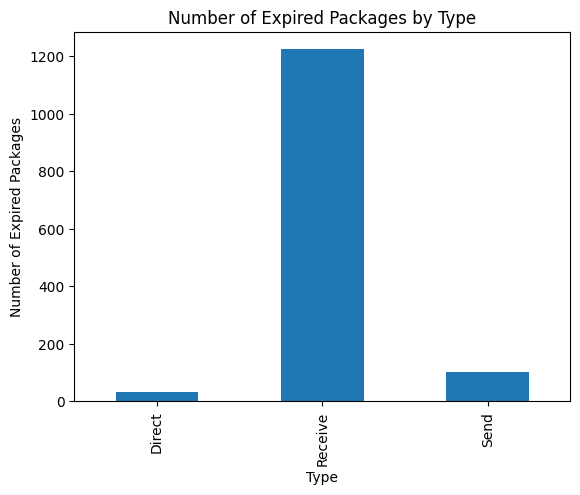

In [12]:
# Plot number of Expired, grouped by Type
%matplotlib inline
import matplotlib.pyplot as plt
expired_counts = df[df['Expired']].groupby('Type').size()
expired_counts.plot(kind='bar')
plt.title('Number of Expired Packages by Type')
plt.xlabel('Type')
plt.ylabel('Number of Expired Packages')
plt.show()

# Feature Engineering
1. Convert Delivery Date into Hour-of-Day, Day-of-Week
2. Extract Occupation Duration = Withdraw Date - Delivery Date
3. Enrich with Weather API data (optional)

# Research questions
1. Does the time of day affect the delivery duration?
2. Is there a correlation between weather conditions and delivery delays?
3. How does the occupation duration impact the overall delivery time?

In [13]:
# Convert Delivery Date into Hour-of-Day and Day-of-Week
df['Delivery Hour'] = df['Delivery Date'].dt.hour
df['Delivery Day of Week'] = df['Delivery Date'].dt.dayofweek

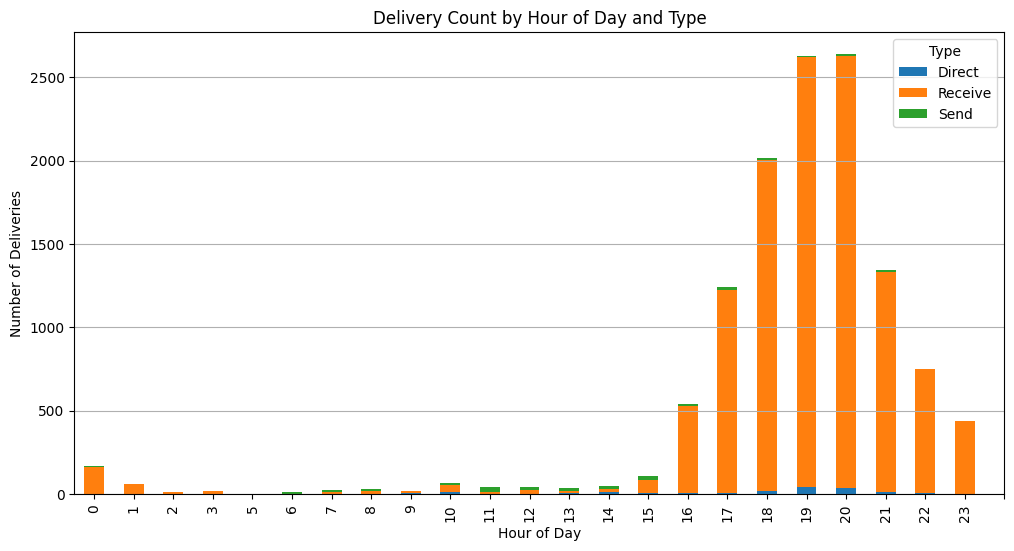

In [14]:
# Stacked bar plot of delivery hour count by Type
delivery_hour_type = df.groupby(['Delivery Hour', 'Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
delivery_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Hour of Day')
plt.ylabel('Number of Deliveries')
plt.title('Delivery Count by Hour of Day and Type')
plt.xticks(range(24))
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

1. Packages tend to be delivered during the peak hours between 5PM to 8PM
2. Most are for "Receive" orders

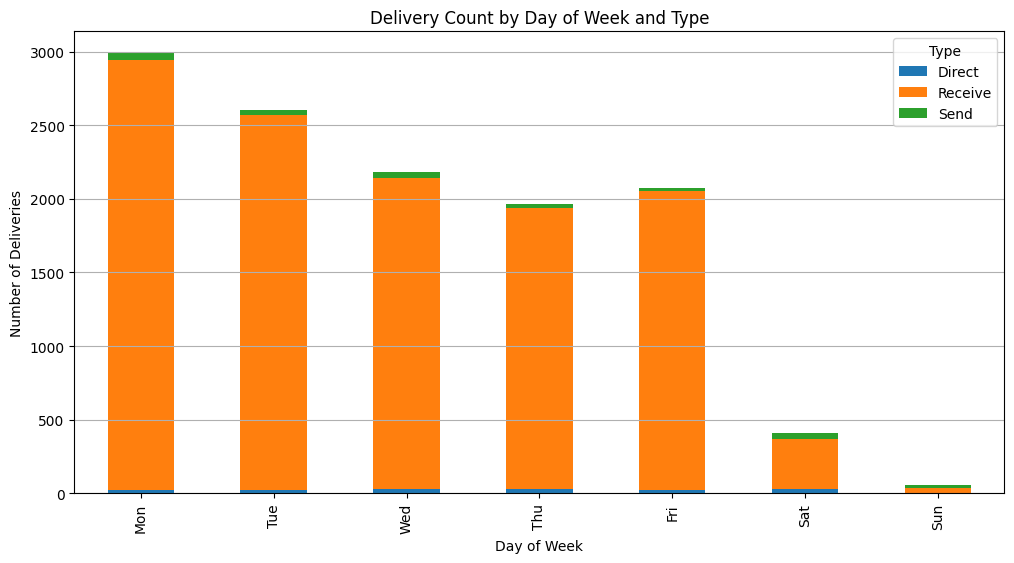

In [15]:
# Stacked bar plot of delivery hour count by Type
DAY_OF_WEEK = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
delivery_hour_type = df.groupby(['Delivery Day of Week', 'Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
delivery_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Day of Week')
plt.ylabel('Number of Deliveries')
plt.title('Delivery Count by Day of Week and Type')
plt.xticks(range(7), DAY_OF_WEEK)
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

1. The peak hours for the package to arrive at the locker is from 6PM-8PM, mostly to due to "Receive" package
2. The number of package delivered to the locker tends to decline throughout the days, reach its lowest point on weekends.

In [16]:
# Convert Delivery Date into Hour-of-Day and Day-of-Week
df['Withdraw Hour'] = df['Withdraw Date'].dt.hour
df['Withdraw Day of Week'] = df['Withdraw Date'].dt.dayofweek

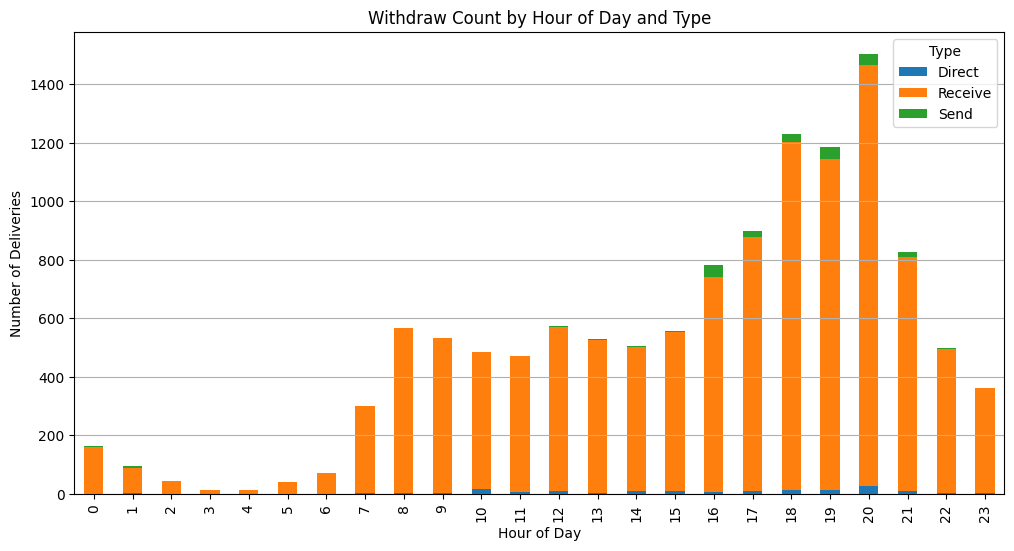

In [17]:
# Stacked bar plot of delivery hour count by Type
delivery_hour_type = df.groupby(['Withdraw Hour', 'Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
delivery_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Hour of Day')
plt.ylabel('Number of Deliveries')
plt.title('Withdraw Count by Hour of Day and Type')
plt.xticks(range(24))
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

1. The packages of "Receive" are more uniformly picked up throughout the days, however, the peak hours for pickups are still between 5PM to 8PM.

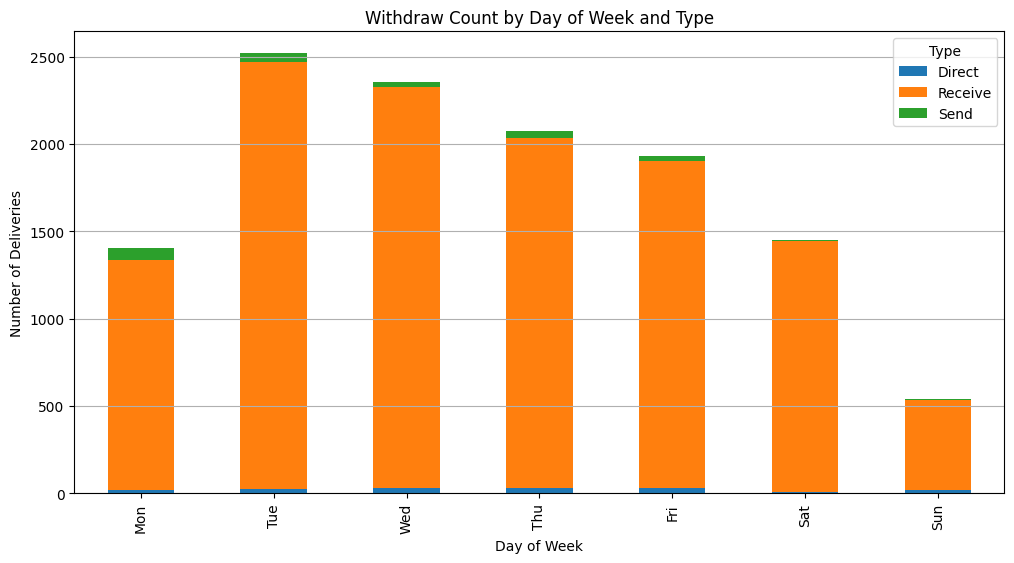

In [18]:
# Stacked bar plot of delivery hour count by Type
DAY_OF_WEEK = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
delivery_hour_type = df.groupby(['Withdraw Day of Week', 'Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
delivery_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Day of Week')
plt.ylabel('Number of Deliveries')
plt.title('Withdraw Count by Day of Week and Type')
plt.xticks(range(7), DAY_OF_WEEK)
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

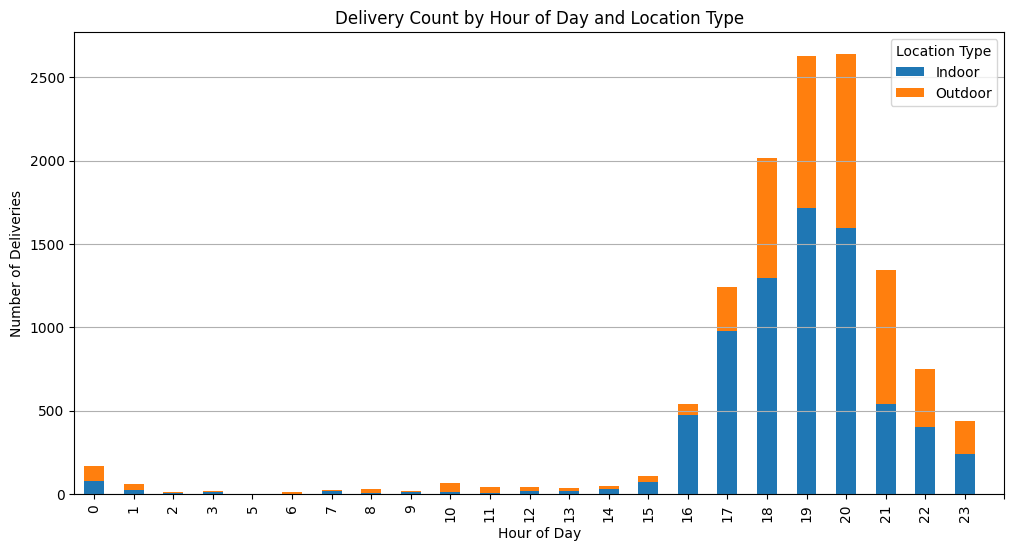

In [19]:
# Stacked bar plot of delivery hour count by Location Type
delivery_hour_type = df.groupby(['Delivery Hour', 'Location Type']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
delivery_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Hour of Day')
plt.ylabel('Number of Deliveries')
plt.title('Delivery Count by Hour of Day and Location Type')
plt.xticks(range(24))
plt.legend(title='Location Type')
plt.grid(axis='y')
plt.show()

## Occupation Duration Inspection

**Questions:**
1. Does the delivery hour and type affect the occupation duration?
2. What are the outliers in occupation duration for each locker box?
3. How does the occupation duration vary across different locker boxes?

In [20]:
# Occupation Duration
df['Occupation Duration'] = (df['Withdraw Date'] - df['Delivery Date']).dt.total_seconds() / 3600

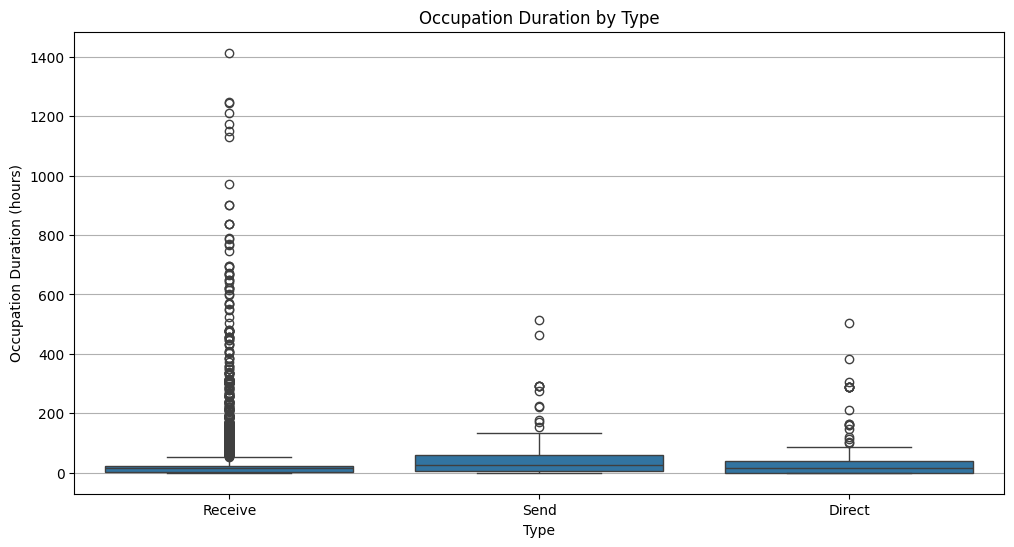

In [21]:
import seaborn as sns
# Plot the boxplot of Occupation Duration by Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Type', y='Occupation Duration', ax=plt.gca())
plt.xlabel('Type')
plt.ylabel('Occupation Duration (hours)')
plt.title('Occupation Duration by Type')
plt.grid(axis='y')
plt.show()

1. "Receive" order usually has the highest occupation duration, upto 2 months
2. The occupation duration of "Send" and "Direct" are roughly the same

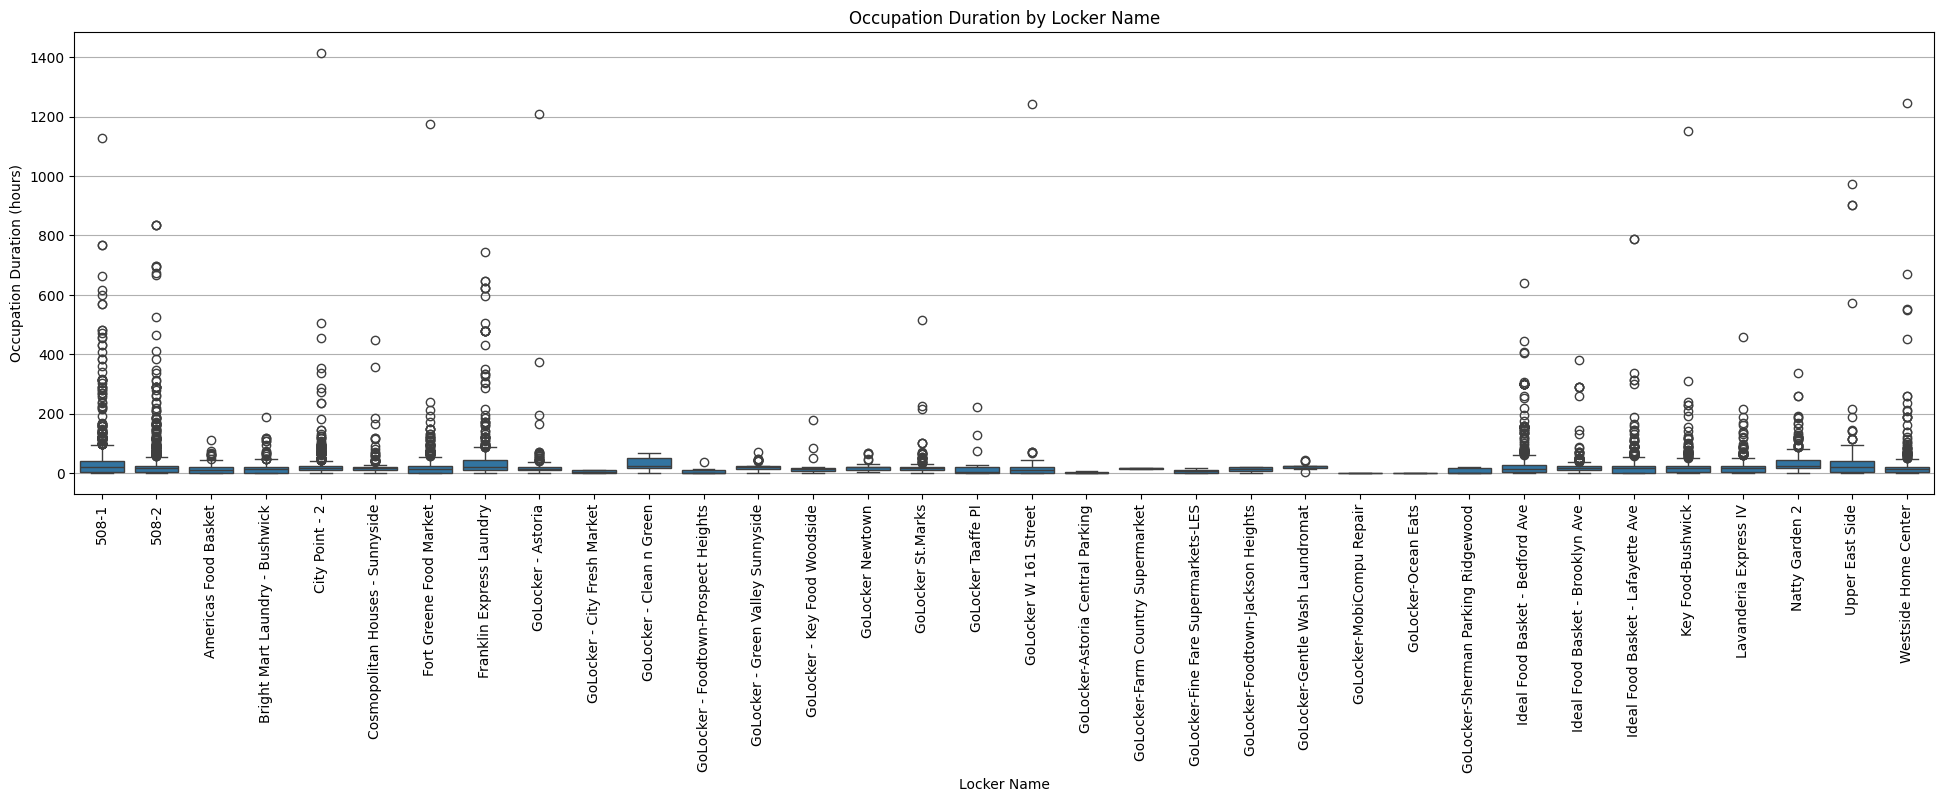

In [22]:
# Plot the boxplot of Occupation Duration by Locker Name
plt.figure(figsize=(24, 6))
sns.boxplot(data=df, x='Locker Name', y='Occupation Duration', ax=plt.gca())
plt.xlabel('Locker Name')
plt.xticks(rotation=90)
plt.ylabel('Occupation Duration (hours)')
plt.title('Occupation Duration by Locker Name')
plt.grid(axis='y')
plt.show()

In [23]:
df[(df["Locker Name"] == "508-1") & (df["Occupation Duration"] > 1000)][["Type", "Created Date", "Receive Date", "Delivery Date", "Expire Date", "Withdraw Date", "Occupation Duration"]]

,Type,Created Date,Receive Date,Delivery Date,Expire Date,Withdraw Date,Occupation Duration
271,Receive,2024-05-23 14:50:00,2024-05-23 14:50:00,2024-05-23 17:22:00,2024-05-26 17:22:00,2024-07-09 17:53:00,1128.516667


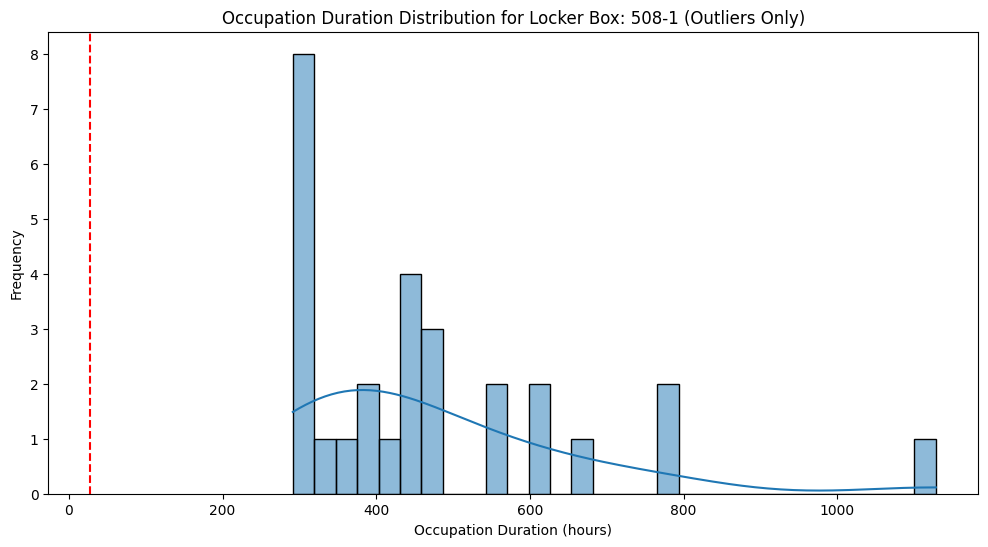

In [24]:
# 1. Extract all outliers of Occupation Duration index
# 2. Query for these records, and visualize the histogram of Locker Box Name has the most outliers
occupation_duration_outliers = df['Occupation Duration'].quantile(0.99)
outliers = df[df['Occupation Duration'] > occupation_duration_outliers]
most_outliers_locker_box = outliers['Locker Name'].value_counts().idxmax()
most_outliers_locker_box_count = outliers['Locker Name'].value_counts().max()

plt.figure(figsize=(12, 6))
sns.histplot(data=outliers[outliers['Locker Name'] == most_outliers_locker_box], x='Occupation Duration', bins=30, kde=True, ax=plt.gca())
plt.xlabel('Occupation Duration (hours)')
plt.ylabel('Frequency')
plt.title(f'Occupation Duration Distribution for Locker Box: {most_outliers_locker_box} (Outliers Only)')
plt.axvline(x=most_outliers_locker_box_count, color='r', linestyle='--')
plt.show()

1. Each locker exists different outliers, which shows that the occupation duration can vary significantly based on the locker location.

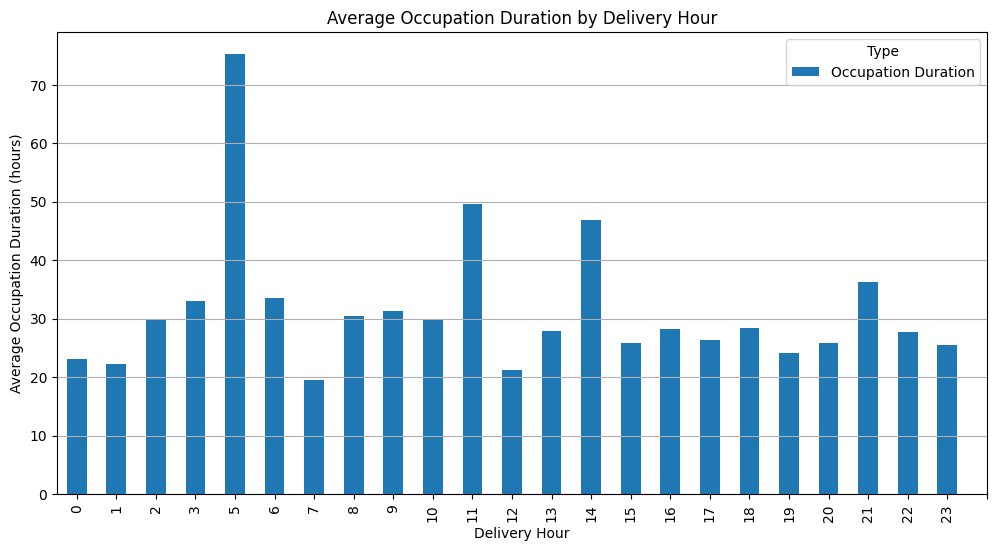

In [25]:
# Stacked chart of Occupation Duration by Delivery Hour, stacked by Type
occupation_by_hour_type = df.groupby('Delivery Hour')['Occupation Duration'].mean()
plt.figure(figsize=(12, 6))
occupation_by_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Delivery Hour')
plt.ylabel('Average Occupation Duration (hours)')
plt.title('Average Occupation Duration by Delivery Hour')
plt.xticks(range(24))
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

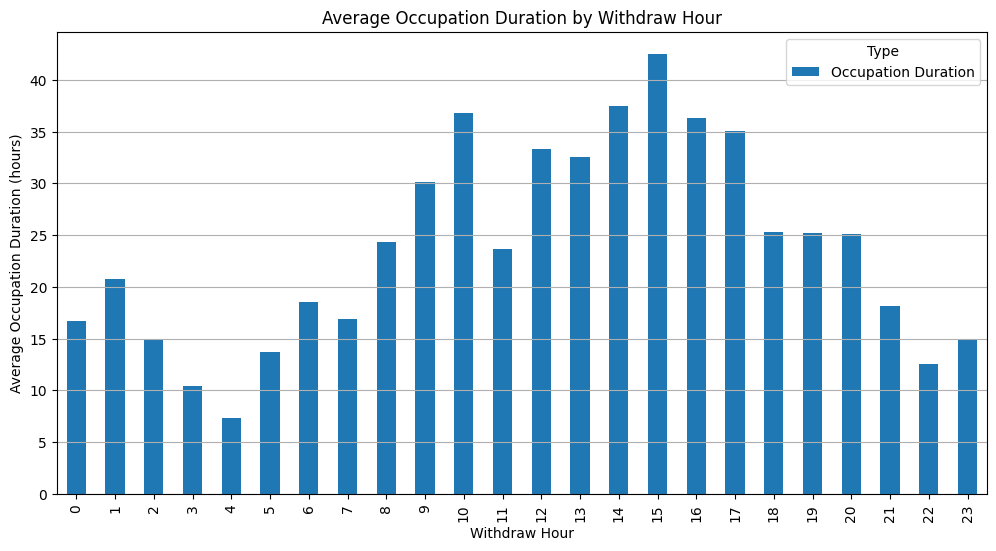

In [26]:
# Stacked chart of Occupation Duration by Withdraw Hour, stacked by Type
occupation_by_hour_type = df.groupby('Withdraw Hour')['Occupation Duration'].mean()
plt.figure(figsize=(12, 6))
occupation_by_hour_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Withdraw Hour')
plt.ylabel('Average Occupation Duration (hours)')
plt.title('Average Occupation Duration by Withdraw Hour')
plt.xticks(range(24))
plt.legend(title='Type')
plt.grid(axis='y')
plt.show()

1. Overall, packages delivered to the lockers at 5 AM, 11 AM and 2PM tend to have longer occupation durations.

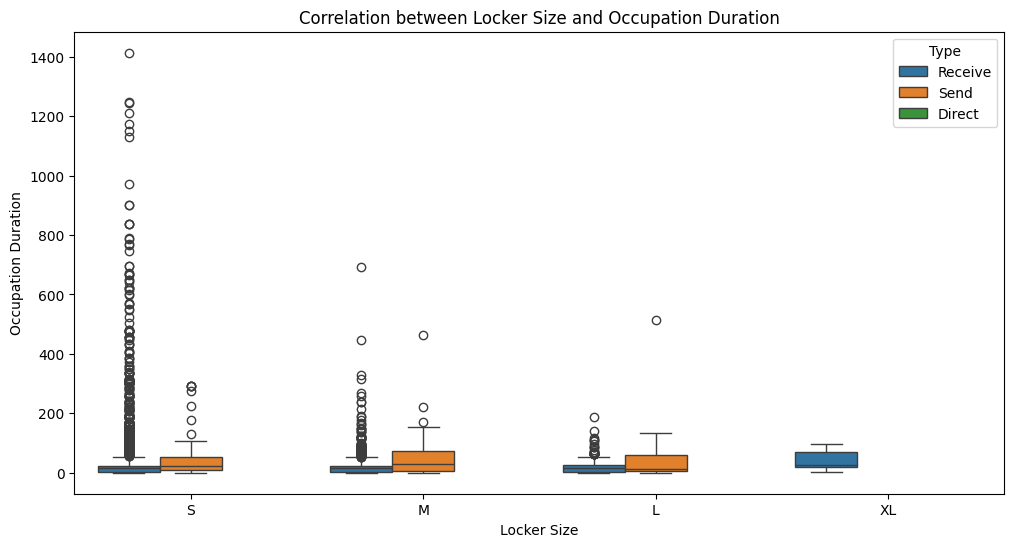

In [27]:
# Show the correlation between locker size and occupation duration using box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Locker Size", y="Occupation Duration", hue="Type")
plt.title("Correlation between Locker Size and Occupation Duration")
plt.xlabel("Locker Size")
plt.ylabel("Occupation Duration")
plt.legend(title="Type")
plt.show()

1. The occupation duration tends to decreases with larger locker sizes
2. And "Receive" service tends to occupy more time compared to other services

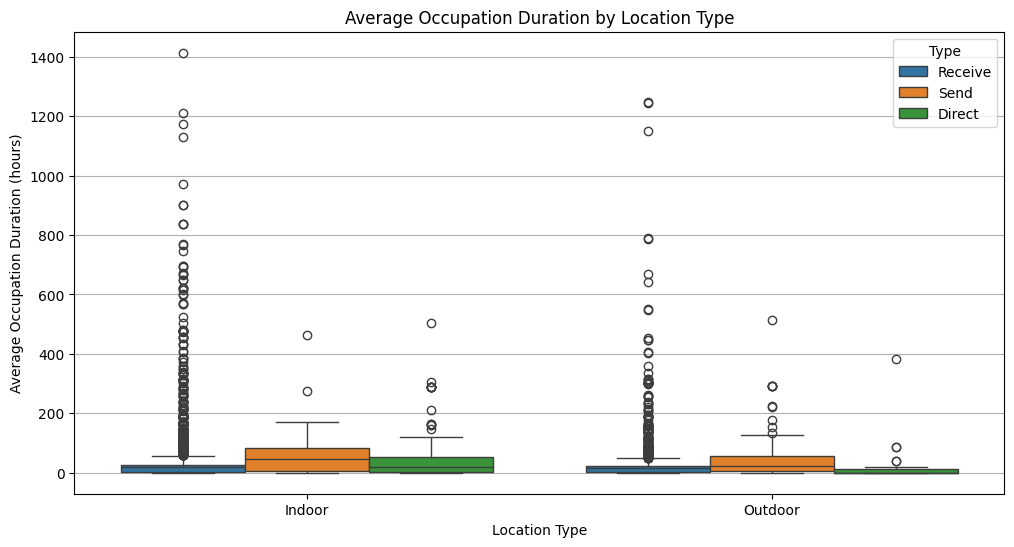

In [28]:
# Using boxplot, plot the average occupation duration by location type  
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location Type', y='Occupation Duration', hue="Type", data=df)
plt.xlabel('Location Type')
plt.ylabel('Average Occupation Duration (hours)')
plt.title('Average Occupation Duration by Location Type')
plt.grid(axis='y')
plt.show()

The occupation durations are roughly the same, regardless of location type.

The machine learning model should take into accounts the current time features, locker-specific attributes, and possibly external factors like weather and geo-location data to predict the hourly package counts for each locker.
Desired inputs:
- Locker Name: unique identifier for each locker
- Location Type (e.g., residential, commercial) - One-hot encode
- Locker Size (e.g., small, medium, large) - One-hot encode
- Delivery Time (Hour of Day, Day of Week, Month)
- Weather Data (Optional)
- Geo-location Data (Optional)

Outputs:
- Hourly package counts for each locker

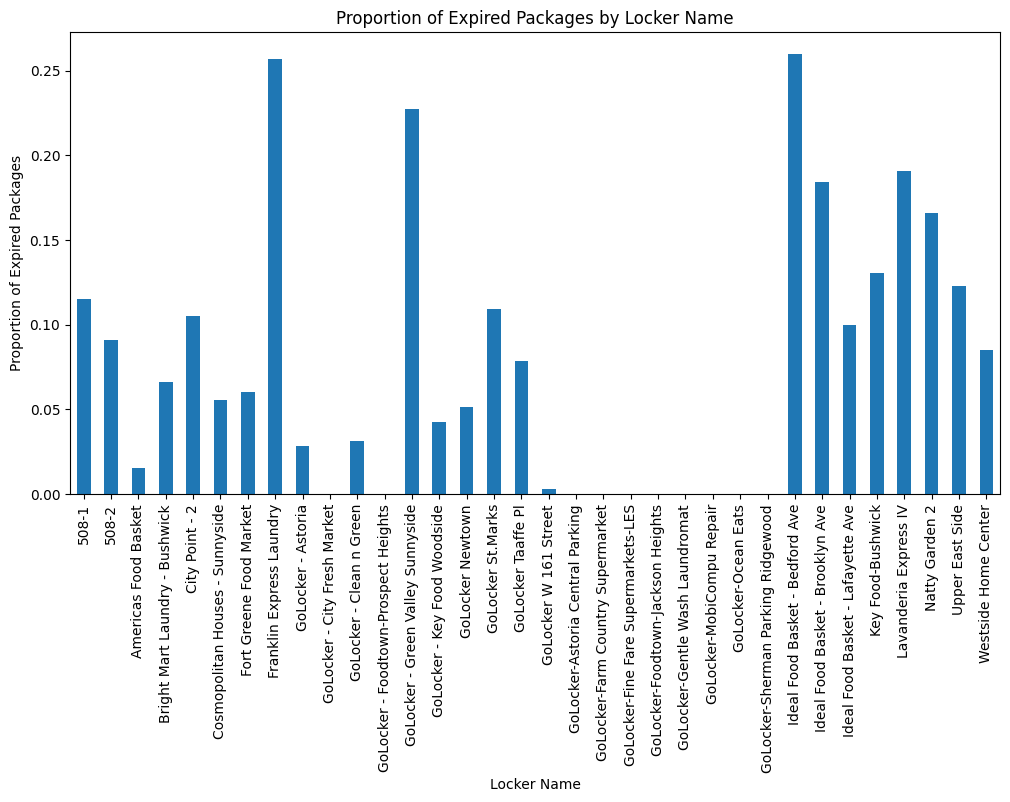

In [55]:
# Plot the proportion of expired packages by locker name
expired_counts = df[df['Expired']].groupby('Locker Name').size()
total_counts = df.groupby('Locker Name').size()
expired_proportions = expired_counts / total_counts
expired_proportions.plot(kind='bar', figsize=(12, 6))
plt.title('Proportion of Expired Packages by Locker Name')
plt.xlabel('Locker Name')
plt.ylabel('Proportion of Expired Packages')
plt.show()

In [56]:
# Remove rows with expired packages
df = df[~df['Expired']]

In [57]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Feature engineering pipeline for hourly package counts prediction
def feature_engineer(df):
    _df = df.copy()
    _df['Date Hour'] = _df['Delivery Date'].dt.floor('h')
    _df.dropna(subset=['Locker Size'], inplace=True)

    # One-hot encode categorical features
    categorical_cols = []
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(_df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=_df.index)

    # Binary encode Location Type
    _df['IsIndoor'] = (_df['Location Type'] == 'Indoor').astype(int)

    # Merge encoded features
    _df = pd.concat([_df, encoded_df], axis=1)

    # Aggregate hourly package counts for each locker
    features = ['IsIndoor'] + list(encoded_df.columns)
    hourly_counts = _df.groupby(['Locker Name', 'Date Hour', 'Locker Size'])[features].first()
    hourly_counts['package_count'] = _df.groupby(['Locker Name', 'Date Hour', 'Locker Size']).size()
    hourly_counts = hourly_counts.reset_index()

    # Aggregate hourly withdraw counts
    _df['Withdraw Date Hour'] = _df['Withdraw Date'].dt.floor('h')
    withdraw_hourly = _df.groupby(['Locker Name', 'Withdraw Date Hour', 'Locker Size'])[features].first()
    withdraw_hourly['withdraw_count'] = _df.groupby(['Locker Name', 'Withdraw Date Hour', 'Locker Size']).size()
    withdraw_hourly = withdraw_hourly.reset_index()

    # Pivot Locker Size to separate count columns for delivery
    unique_sizes = _df['Locker Size'].unique()
    hourly_counts = hourly_counts.pivot(index=['Locker Name', 'Date Hour'] + features, columns='Locker Size', values='package_count').fillna(0).reset_index()
    
    # # Add time features from Date Hour
    # hourly_counts['Hour'] = hourly_counts['Date Hour'].dt.hour
    # hourly_counts['Day of Week'] = hourly_counts['Date Hour'].dt.dayofweek
    # hourly_counts['Month'] = hourly_counts['Date Hour'].dt.month
    
    # Rename the pivoted columns
    for size in unique_sizes:
        if size in hourly_counts.columns:
            hourly_counts.rename(columns={size: f'size_{size}_delivery'}, inplace=True)

    # Pivot for withdraw
    withdraw_hourly = withdraw_hourly.pivot(index=['Locker Name', 'Withdraw Date Hour'] + features, columns='Locker Size', values='withdraw_count').fillna(0).reset_index()
    
    # # Add time features from Withdraw Date Hour
    # withdraw_hourly['Hour'] = withdraw_hourly['Withdraw Date Hour'].dt.hour
    # withdraw_hourly['Day of Week'] = withdraw_hourly['Withdraw Date Hour'].dt.dayofweek
    # withdraw_hourly['Month'] = withdraw_hourly['Withdraw Date Hour'].dt.month
    
    # Rename
    for size in unique_sizes:
        if size in withdraw_hourly.columns:
            withdraw_hourly.rename(columns={size: f'size_{size}_withdraw'}, inplace=True)

    # Rename 'Withdraw Date Hour' to 'Date Hour' for merging
    withdraw_hourly.rename(columns={'Withdraw Date Hour': 'Date Hour'}, inplace=True)

    # Merge on Locker Name, Date Hour, and non-time features
    hourly_counts = pd.merge(hourly_counts, withdraw_hourly, on=['Locker Name', 'Date Hour'] + features, how='outer').fillna(0)

    # hourly_counts['Hour'] = hourly_counts['Date Hour'].dt.hour
    # hourly_counts['Day of Week'] = hourly_counts['Date Hour'].dt.dayofweek
    # hourly_counts['Month'] = hourly_counts['Date Hour'].dt.month
    return hourly_counts

# Example usage:
# engineered_df = feature_engineer(df, weather_df=None, geo_df=None)
engineered_df = feature_engineer(df)
engineered_df.head()

Locker Size,Locker Name,Date Hour,IsIndoor,size_L_delivery,size_M_delivery,size_S_delivery,size_XL_delivery,size_L_withdraw,size_M_withdraw,size_S_withdraw,size_XL_withdraw
0,508-1,2024-04-10 18:00:00,1,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
1,508-1,2024-04-10 19:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,508-1,2024-04-11 12:00:00,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,508-1,2024-04-11 14:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,508-1,2024-04-11 15:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


# Data Enrichment
1. Holiday feature
2. Weather data (temperature, precipitation, etc.) - Optional

In [ ]:
# us_holidays = holidays.US()
# engineered_df['IsHoliday'] = engineered_df['Date Hour'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)
# engineered_df.head()

Locker Size,Locker Name,Date Hour,IsIndoor,size_L_delivery,size_M_delivery,size_S_delivery,size_XL_delivery,size_L_withdraw,size_M_withdraw,size_S_withdraw,size_XL_withdraw,Hour,Day of Week,Month,IsHoliday
0,508-1,2024-04-10 18:00:00,1,1.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,18,2,4,0
1,508-1,2024-04-10 19:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19,2,4,0
2,508-1,2024-04-11 12:00:00,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,12,3,4,0
3,508-1,2024-04-11 14:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,3,4,0
4,508-1,2024-04-11 15:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,15,3,4,0


In [58]:
engineered_df.head(10)

Locker Size,Locker Name,Date Hour,IsIndoor,size_L_delivery,size_M_delivery,size_S_delivery,size_XL_delivery,size_L_withdraw,size_M_withdraw,size_S_withdraw,size_XL_withdraw
0,508-1,2024-04-10 18:00:00,1,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
1,508-1,2024-04-10 19:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,508-1,2024-04-11 12:00:00,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,508-1,2024-04-11 14:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,508-1,2024-04-11 15:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,508-1,2024-04-11 16:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,508-1,2024-04-12 16:00:00,1,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
7,508-1,2024-04-12 18:00:00,1,0.0,1.0,0.0,0.0,2.0,1.0,3.0,0.0
8,508-1,2024-04-13 18:00:00,1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
9,508-1,2024-04-14 12:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


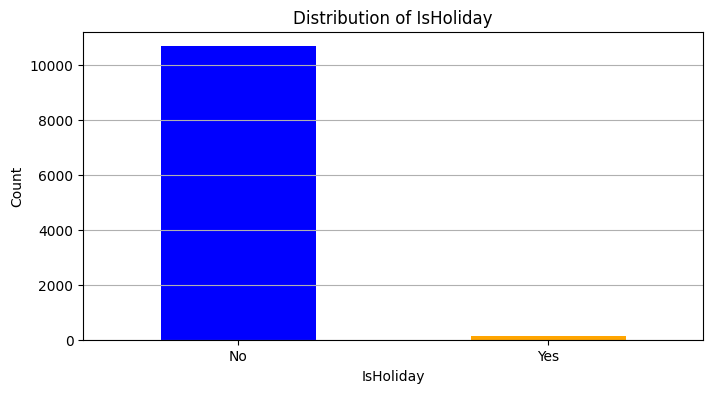

In [46]:
# Histogram of IsHoliday
plt.figure(figsize=(8, 4))
engineered_df['IsHoliday'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of IsHoliday')
plt.xlabel('IsHoliday')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.grid(axis='y')
plt.show()

In [35]:
# Plot the package counts of each size "size_S_counts", size_M_counts, size_L_counts, size_XL_counts for by IsHoliday
plt.figure(figsize=(12, 6))
engineered_df.groupby('IsHoliday')[['size_S_counts', 'size_M_counts', 'size_L_counts', 'size_XL_counts']].max().plot(kind='bar', ax=plt.gca())
plt.title('Package Counts by Size and Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Total Package Counts')
plt.legend(title='Locker Size')
plt.grid(axis='y')
plt.show()

KeyError: "Columns not found: 'size_XL_counts', 'size_M_counts', 'size_S_counts', 'size_L_counts'"

<Figure size 1200x600 with 0 Axes>

In [ ]:
engineered_df.to_csv("dataset/locker_nyc_engineered.csv", index=False)

In [59]:
# Split into sub-locker dataset
LOCKER_NAMES = engineered_df['Locker Name'].unique().tolist()
sub_locker_dfs = {name: engineered_df[engineered_df['Locker Name'] == name].copy() for name in LOCKER_NAMES}
# Export each sub-locker dataset to CSV
for name, sub_df in sub_locker_dfs.items():
    sub_df.drop(columns=["Locker Name"], inplace=True)
    # Lowercase and replace spaces with underscores in name
    name = name.replace(" - ", "_").replace(" ", "_")
    name = name.lower()
    sub_df.to_csv(f"dataset/lockers/{name}.csv", index=False)